In [1]:
import json
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Load Data

In [2]:
def load_iscream(fpath='iscream_public_edu_v3.txt'):
    
    with open(fpath, 'r') as f:
        lines = f.readlines()
        
    lines = [json.loads(line.strip().replace("'","\"")) for line in lines]
    
    df = pd.DataFrame(columns=lines[0].keys())
    for user in lines:
        df = df.append(pd.Series(user), ignore_index=True)
        
    return df

In [3]:
%%time
df = load_iscream()

Wall time: 17.6 s


# Sanity Check
4개의 column들이 모두 같은 길이를 가지는 지 확인

In [4]:
def check_sanity(line):
    return True if len(set(len(_) for _ in line)) > 1 else False

sanity_condition = df.apply(check_sanity, axis=1)
df[sanity_condition]

,assessmentItemID,testId,answerCode,Timestamp


# Item Number Check

고유아이템 개수와 번호 이빨빠진 것 확인

In [5]:
from itertools import chain

In [6]:
item_ids = list(chain(*df['assessmentItemID'].values))
test_ids = list(chain(*df['testId'].values))

## Assessment Item ID - 문제 체크

In [7]:
info = f'''
총 Interaction 수: {len(item_ids)}
고유 assessmentItemID수: {len(set(item_ids))}
'''
print(info)


총 Interaction 수: 2526700
고유 assessmentItemID수: 9454



**보고 받았던 Interaction 수가 153만 건**인 것과 비교하면 상당히 많은 수네요.   
또한 문항의 경우 **고유 문항이 6,631건인 것과 비교해도 고유 문항 수가 9,454건**으로 많네요.   
데이터에 대한 정확한 정보가 빨리 넘어왔으면 하는 바람입니다...

In [8]:
item_ids.sort()
item_ids[-1], len(set(item_ids))

(9453, 9454)

이빨 빠진 것 없이 0부터 9453번까지 있네요.

## Test ID - 시험지 체크

In [9]:
info = f'''
총 Interaction 수: {len(test_ids)}
고유 TestID(시험지): {len(set(test_ids))}
'''
print(info)


총 Interaction 수: 2526700
고유 TestID(시험지): 1537



**보고 받았던 고유 시험지의 수는 1,165개**로,   
실제 데이터 안에 들어간 고유 시험지의 수인 1,537개와 비교하면 많이 다르네요

In [10]:
test_ids.sort()
test_ids[-1], len(set(test_ids))

(1536, 1537)

이빨 빠진 것 없이 0부터 1536번까지 있네요.

## 순서 정렬 체크

구글 드라이브에 올라온 설명서에 보면 Interaction의 순서가 시간 순서가 **아닐 수** 있다라고 써있더군요. 등골이 서늘합니다. 실제로 체크해보니

In [11]:
from datetime import datetime

In [12]:
df['Timestamp'] = df['Timestamp'].apply(lambda x: list(datetime.fromtimestamp(_) for _ in x))

In [13]:
sorted(df.loc[0, 'Timestamp']) == df.loc[0, 'Timestamp']

False

네, 다르네요. 그러면 어떤 기준으로 정렬되어있는지는...

In [14]:
df.head()

,assessmentItemID,testId,answerCode,Timestamp
0,"[30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 60, 6...","[6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 12, 12, 12, 12,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[2020-03-10 07:09:34, 2020-03-10 07:12:57, 202..."
1,"[40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 60, 6...","[8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 12, 12, 12...","[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2020-03-05 08:33:48, 2020-03-05 08:34:23, 202..."
2,"[3611, 3612, 3613, 3614, 3615, 3616, 3594, 359...","[690, 690, 690, 690, 690, 690, 687, 687, 687, ...","[1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, ...","[2020-08-08 05:49:05, 2020-08-08 05:53:55, 202..."
3,"[3567, 3568, 3569, 3570, 3571, 3572, 3583, 358...","[682, 682, 682, 682, 682, 682, 685, 685, 685, ...","[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[2020-05-26 07:54:27, 2020-05-26 07:55:13, 202..."
4,"[3370, 3371, 3372, 3373, 3374, 3375, 3600, 360...","[644, 644, 644, 644, 644, 644, 688, 688, 688, ...","[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...","[2020-06-19 05:11:01, 2020-06-19 05:11:27, 202..."


언뜻 봐도 시험지 묶음별로 정렬되어 있음을 알 수 있네요.

timestamp 순서로 나머지 Column도 정리하는 코드

In [15]:
def sortby_timestamp(line):
    
    mask = np.array(line['Timestamp']).argsort()
    
    line['assessmentItemID'] = [line['assessmentItemID'][i] for i in mask]
    line['testId'] = [line['testId'][i] for i in mask]
    line['answerCode'] = [line['answerCode'][i] for i in mask]
    line['Timestamp'] = [line['Timestamp'][i] for i in mask]
        
    return line

In [16]:
%%time
df.apply(sortby_timestamp, axis=1)

Wall time: 32.3 s


,assessmentItemID,testId,answerCode,Timestamp
0,"[187, 188, 189, 190, 191, 197, 198, 199, 200, ...","[37, 37, 37, 37, 37, 39, 39, 39, 39, 39, 41, 4...","[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, ...","[2020-02-28 05:51:56, 2020-02-28 06:31:36, 202..."
1,"[263, 264, 265, 266, 267, 40, 41, 42, 43, 44, ...","[52, 52, 52, 52, 52, 8, 8, 8, 8, 8, 10, 10, 10...","[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[2020-02-03 08:42:39, 2020-02-03 08:43:29, 202..."
2,"[3269, 3270, 3271, 3272, 3273, 3365, 3366, 336...","[625, 625, 625, 625, 625, 643, 643, 643, 643, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ...","[2020-04-13 11:05:20, 2020-04-13 11:05:22, 202..."
3,"[3239, 3240, 3241, 3243, 3242, 3269, 3270, 327...","[619, 619, 619, 619, 619, 625, 625, 625, 625, ...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, ...","[2020-02-22 08:11:57, 2020-02-22 08:12:09, 202..."
4,"[3370, 3371, 3372, 3373, 3374, 3375, 3229, 323...","[644, 644, 644, 644, 644, 644, 617, 617, 617, ...","[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[2020-06-19 05:11:01, 2020-06-19 05:11:27, 202..."
...,...,...,...,...
7437,"[3452, 3453, 3454, 3455, 3456, 3457, 3469, 347...","[660, 660, 660, 660, 660, 660, 663, 663, 663, ...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[2020-05-12 06:33:15, 2020-05-12 06:53:36, 202..."
7438,"[79, 80, 81, 82, 83, 84, 85, 86, 95, 96, 97, 9...","[16, 16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 1...","[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2020-05-05 08:05:51, 2020-05-05 08:06:29, 202..."
7439,"[3116, 3117, 3118, 3119, 3120, 3121, 3376, 337...","[595, 595, 595, 595, 595, 595, 645, 645, 645, ...","[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, ...","[2020-02-07 04:28:22, 2020-02-07 04:28:59, 202..."
7440,"[3082, 3083, 3084, 3085, 3086, 3407, 3408, 340...","[589, 589, 589, 589, 589, 651, 651, 651, 651, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, ...","[2020-07-22 08:02:28, 2020-07-22 08:02:56, 202..."


# Number of interactions

## Per student

학생 한 명이 몇 개의 문제를 풀었는지 확인해보는 코드입니다.

In [17]:
num_df = df.loc[:, 'assessmentItemID'].apply(lambda x: len(x))

Text(0, 0.5, '# of Students')

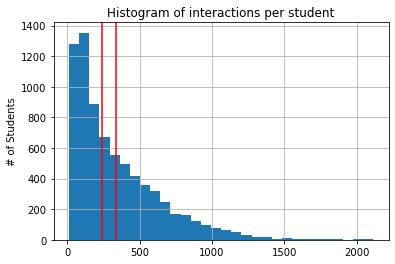

In [18]:
fig, ax = plt.subplots()
num_df.hist(ax=ax, bins=30)
ax.set_title('Histogram of interactions per student')
ax.axvline(x=num_df.mean(), c='r')
ax.axvline(x=num_df.median(), c='r')
ax.set_ylabel('# of Students')

In [19]:
info = f'''
Max# of itracts: {num_df.max()},
Min# of itracts: {num_df.min()}
Median of itracts: {num_df.median()},
Mean of itracts: {num_df.mean():.3f},
'''
print(info)


Max# of itracts: 2113,
Min# of itracts: 12
Median of itracts: 242.0,
Mean of itracts: 339.519,



## Per Question
문제가 각각 몇 번 풀렸는지 확인해보는 코드입니다.

In [20]:
item_count = Counter(item_ids)
item_hist = Counter({v: k for k, v in item_count.items()})

In [21]:
set(item_count.values())

{50, 100, 150, 200, 250, 300, 350, 400, 450, 500}

암만 봐도 이상해서 `Counter`를 써보니 이상하게도 문제 푼 횟수가... 뭔가 고정되어 있네요.   
잘못 본 것인가 확인해봤는데 지후님이 제공해주신 플롯도 굉장히 Quantize 되어있는 걸 확인했습니다.
이상은 없는 것 같군요. 다만 보고 받았던 자료에서 최댓값이 300이었던 것과 비교하면 그 이상 풀린 문제들도 존재하는 걸 확인할 수 있었습니다.

In [22]:
item_hist

Counter({350: 9240,
         300: 9280,
         250: 9320,
         200: 9342,
         150: 9375,
         100: 9419,
         50: 9453,
         400: 9108,
         500: 9056,
         450: 9078})

저걸 해석하면, 50번 풀린 문제가 총 3,056개 있다는 뜻입니다.

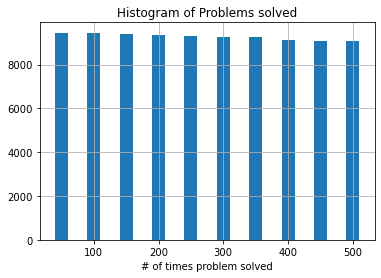

In [23]:
plt.title("Histogram of Problems solved")
plt.bar(item_hist.keys(), item_hist.values(), width=20)
plt.xlabel("# of times problem solved")
plt.grid()

## Per Test

In [24]:
test_count = Counter(test_ids, )
test_hist = Counter({v: k for k, v in test_count.items()})

시험지가 풀린 횟수가 결국엔 문항 풀린 횟수에 의존하게 되니, 이 또한 숫자가 좀 깎여있네요

In [25]:
test_hist

Counter({1750: 1256,
         1400: 1137,
         2800: 1505,
         2100: 1489,
         1050: 1523,
         2450: 136,
         1500: 1517,
         1250: 1160,
         1000: 1158,
         750: 1054,
         500: 1456,
         250: 583,
         200: 581,
         1200: 1524,
         400: 1533,
         300: 1536,
         600: 1531,
         1800: 1511,
         2400: 1509,
         3000: 1476,
         800: 1528,
         3300: 424,
         2700: 1479,
         900: 1525,
         3900: 767,
         350: 1440,
         2000: 1513,
         2250: 1244,
         2500: 955,
         700: 1156,
         2750: 1117,
         1600: 1520,
         3200: 1485,
         4400: 1452,
         4000: 1478,
         3600: 1481})

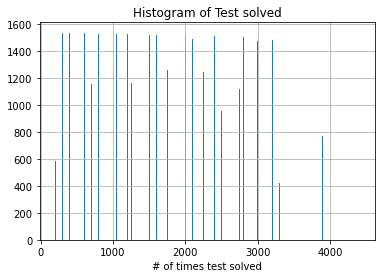

In [26]:
plt.title("Histogram of Test solved")
plt.bar(test_hist.keys(), test_hist.values(), width=10)
plt.xlabel("# of times test solved")
plt.grid()

# 정답률 분석
1. 학생별 정답률
2. 문제별 정답률

을 분석해보았습니다.

## 학생별 정답률

In [27]:
def answer_rate(lst):
    
    answers = np.array(lst)
    return len(answers[answers == 1]) / len(answers)

student_answer_rate = df['answerCode'].apply(answer_rate)

<AxesSubplot:title={'center':'Histogram of Answer rate for each student'}>

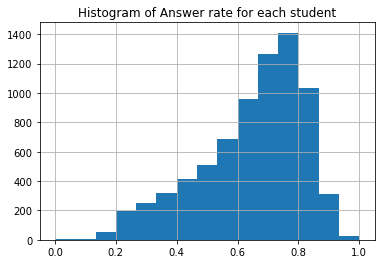

In [28]:
fig, ax = plt.subplots()
ax.set_title('Histogram of Answer rate for each student')
student_answer_rate.hist(ax=ax, bins=15)

In [29]:
df['studentAnswerRate'] = student_answer_rate

## 문항별 정답률

In [30]:
item_ids = list(chain(*df['assessmentItemID'].values))
answer_ids = list(chain(*df['answerCode'].values))
test_ids = list(chain(*df['testId'].values))

In [31]:
item_answer_pairs = [(i, a) for i, a in zip(item_ids, answer_ids)]
test_answer_pairs = [(t, a) for t, a in zip(test_ids, answer_ids)]

In [32]:
item_answer_rate = Counter(item_answer_pairs)

# 쓸만한 Feature가 있는가

주어진 데이터가 너무 작아서 (...) 결국엔
- 어떤 문제를 풀었나
- 문제가 어느 테스트 안에 속해있고
- 문제를 맞췄는지
- 언제 풀었는지

이 정도인데... 생각나는 특성은
1. 문제 푼 사이 시간 (Elapsed time)
2. 푼 문제들이 같은 테스트셋 안에서 연속인지 아닌지

## 앞에 푼 문제로부터 걸린 시간

문제의 sequence가 있을 때 지나간 시간(sec)를 한 번 계산해보았습니다.

In [33]:
def timedelta2float(td):
    
    res = td.microseconds/float(1000000) + (td.seconds + td.days * 24 * 3600)
    return res

def calculate_elapsed(lst):
    
    return [0.] + [timedelta2float(lst[i+1] - lst[i]) for i, _ in enumerate(lst[:-1])]

In [34]:
elapsed = df['Timestamp'].apply(calculate_elapsed)

In [35]:
elapsed

0       [0.0, 2380.0, 28.0, 63.0, 15.0, 320781.0, 90.0...
1       [0.0, 50.0, 113.0, 74.0, 41.0, 2677591.0, 35.0...
2       [0.0, 2.0, 7.0, 29.0, 7.0, 3371407.0, 3.0, 2.0...
3       [0.0, 12.0, 29.0, 592.0, 3107.0, 2946643.0, 65...
4       [0.0, 26.0, 19.0, 8.0, 34.0, 14.0, 1135597.0, ...
                              ...                        
7437    [0.0, 1221.0, 7.0, 11.0, 1010.0, 30.0, 601238....
7438    [0.0, 38.0, 6.0, 18.0, 30.0, 27.0, 22.0, 16.0,...
7439    [0.0, 37.0, 30.0, 148.0, 22.0, 24.0, 11852270....
7440    [0.0, 28.0, 90.0, 22.0, 13.0, 68677.0, 84.0, 2...
7441    [0.0, 4.0, 3.0, 3.0, 6.0, 15.0, 13089759.0, 37...
Name: Timestamp, Length: 7442, dtype: object

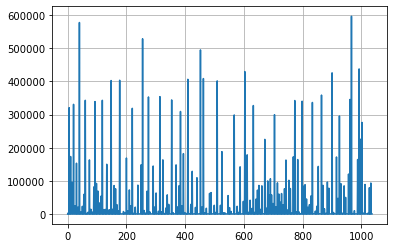

In [36]:
plt.plot(elapsed[0])
plt.grid()

In [37]:
df['Elapsed'] = elapsed

## 시험지를 연속으로 풀었는가


In [38]:
sample = df.loc[0, 'testId']

In [39]:
def test_consecutive(lst):
    
    return [1] + [1 if lst[i] == lst[i-1] else 0 for i in range(1, len(lst))]

In [40]:
consecutive = df['testId'].apply(test_consecutive)

In [44]:
df['testId']

0       [37, 37, 37, 37, 37, 39, 39, 39, 39, 39, 41, 4...
1       [52, 52, 52, 52, 52, 8, 8, 8, 8, 8, 10, 10, 10...
2       [625, 625, 625, 625, 625, 643, 643, 643, 643, ...
3       [619, 619, 619, 619, 619, 625, 625, 625, 625, ...
4       [644, 644, 644, 644, 644, 644, 617, 617, 617, ...
                              ...                        
7437    [660, 660, 660, 660, 660, 660, 663, 663, 663, ...
7438    [16, 16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 1...
7439    [595, 595, 595, 595, 595, 595, 645, 645, 645, ...
7440    [589, 589, 589, 589, 589, 651, 651, 651, 651, ...
7441    [655, 655, 655, 655, 655, 655, 686, 686, 686, ...
Name: testId, Length: 7442, dtype: object

In [41]:
consecutive

0       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...
1       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...
2       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, ...
3       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...
4       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...
                              ...                        
7437    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...
7438    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...
7439    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...
7440    [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...
7441    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...
Name: testId, Length: 7442, dtype: object

In [42]:
df['testConsecutive'] = consecutive

# 데이터 구성
그래서 모델링을 어떻게할 것이냐를 구상하고, 이를 통해 데이터를 어떻게 짤 것이냐, 즉 `DataLoader`를 어떻게 짤 것인지를 고민해봐야할 것 같습니다.

기본적으로 저희가 가지고 있는 자원은
+ BERTEncoder
+ SAINT(Encoder-Decoder Architecture)

인데 결국에는 임베딩을 하는 방식은 같고, 어떤 임베딩 결과를 Encoder에 넣어줄 것인지, Decoder에 넣어줄 것인지를 고민하면 될 것 같습니다.
우선 두 방식 모두 고정된 길이의 Sequence_length를 요구하므로 첫 번째 Hyperparameter를 정해주면
+ `seq_len=256`

로 정합시다. 평균적으로 한 학생이 푼 문항의 수가 339문항이고, 중앙값은 212를 가지는 것을 감안했을 때 정한 숫자입니다. 이건 바꿔가면서 조절할 수 있을 것 같네요.